In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from torch.utils.tensorboard import SummaryWriter

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("GPU is not available.")

GPU is available.


## HRL Model

### Pool Release Agent

In [30]:
class PRANetwork(nn.Module):
    def __init__(self, input_dim=5, embedding_dim=128, hidden_dims=[256, 128], output_dim=2):
        super(PRANetwork, self).__init__()
        self.feature_extractor = nn.Linear(input_dim, embedding_dim)
        layers = []
        for i in range(len(hidden_dims)):
            in_dim = embedding_dim if i == 0 else hidden_dims[i-1]
            out_dim = hidden_dims[i]
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU())
        self.ff_network = nn.Sequential(*layers)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
    
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.ff_network(x)
        x = self.output_layer(x)
        x = F.softmax(x, dim=-1)
        return x


### Route Planning Agent

In [31]:
class Encoder(nn.Module):
    def __init__(self, dim, num_heads, num_layers, order_dim=7, crowdsource_dim=5, inhouse_dim=3):
        super(Encoder, self).__init__()
        self.order_embedding = nn.Linear(order_dim, dim)                # order_dim = 7
        self.crowdsource_embedding = nn.Linear(crowdsource_dim, dim)    # crowdsource_dim = 5
        self.inhouse_embedding = nn.Linear(inhouse_dim, dim)            # inhouse_dim = 3
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, num_heads, batch_first=True) for _ in range(num_layers)])
        self.norm_layers = nn.ModuleList([nn.BatchNorm1d(dim) for _ in range(num_layers)])

    def forward(self, x_o, x_c, x_i):
        h_o = self.order_embedding(x_o)
        h_c = self.crowdsource_embedding(x_c)
        h_i = self.inhouse_embedding(x_i)
        
        x = torch.cat((h_o, h_c, h_i), dim=0)
        
        for multi_head_attn, norm in zip(self.layers, self.norm_layers):
            attn_output, _ = multi_head_attn(x, x, x)
            x = x + attn_output
            x = norm(x)
            x = x + F.relu(x)
            x = norm(x)
        return x

class Decoder(nn.Module):
    def __init__(self, dim, output_dim, total_nodes, S, num_heads, is_cdrpa=False):
        super(Decoder, self).__init__()
        self.multi_head_attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.cdrpa_embedding = nn.Linear(dim*2+1+1, dim)
        self.cvrpa_embedding = nn.Linear(dim*2+1, dim)
        self.is_cdrpa = is_cdrpa
        self.W_Qs = nn.Linear(dim, dim)
        self.W_Ks = nn.Linear(dim, dim)
        self.output_layer = nn.Linear(total_nodes, output_dim)
        self.S = S

    def forward(self, context, H, mask):
        if self.is_cdrpa:
            context = self.cdrpa_embedding(context)
        else: 
            context = self.cvrpa_embedding(context)
            
        H_c_t, _ = self.multi_head_attn(context, H, H)
        Qs = self.W_Qs(H_c_t)
        Ks = self.W_Ks(H)

        u = self.S * torch.tanh((Qs @ Ks.transpose(0, 1)) / torch.sqrt(torch.tensor(Qs.size(-1), dtype=torch.float32)))
        u = u.masked_fill(mask, float('-inf'))
        
        output = self.output_layer(u)
        
        return F.softmax(output, dim=1)
    
class RoutePolicyNetwork(nn.Module):
    def __init__(self, dim, S, num_heads, num_layers):
        super(RoutePolicyNetwork, self).__init__()
        self.encoder = Encoder(dim, num_heads, num_layers)
        
    def forward(self, P_o, P_c, P_i):
        P_c = sorted(P_c, key=lambda x: x['l_c'])           # Sorting crowdsource with latest depature time l_c
        
        x_o = torch.tensor([[*o['v_o'], *o['d_o'], o['e_o'], o['l_o'], o['w_o']] for o in P_o], dtype=torch.float32)
        x_c = torch.tensor([[*c['u_c'], c['a_c'], c['l_c'], c['q_c']] for c in P_c], dtype=torch.float32)
        x_i = torch.tensor([[*i['u_i'], i['q_i']] for i in P_i], dtype=torch.float32)
        
        H_N = self.encoder(x_o, x_c, x_i)                   # Embedding graph -> forward pass
        
        h_o = H_N[:x_o.shape[0], :].clone()
        h_c = H_N[x_o.shape[0]:x_o.shape[0]+x_c.shape[0], :].clone()
        h_i = H_N[x_o.shape[0]+x_c.shape[0]:, :].clone()
        
        assert h_o.shape[0] == x_o.shape[0], 'Invalid shape'
        assert h_c.shape[0] == x_c.shape[0], 'Invalid shape'
        assert h_i.shape[0] == x_i.shape[0], 'Invalid shape'
        
        h_N_mean = torch.mean(H_N, dim=0)     # Global graph embedding
        
        # print(H_N.shape)
        # print(h_N_mean.shape)
        # print(f"Total Orders: {x_o.size(0)}")
        # print(f"Total Crowdsources: {x_c.size(0)}")
        # print(f"Total Inhouses: {x_i.size(0)}")
        
        # output_dim must be the number of the order nodes
        decoder_cdrpa = Decoder(dim=128, output_dim=x_o.size(0), S=1, total_nodes=H_N.size(0), num_heads=8, is_cdrpa=True)
        decoder_cvrpa = Decoder(dim=128, output_dim=x_o.size(0), S=1, total_nodes=H_N.size(0), num_heads=8)

        S_CDPRA_t = copy.deepcopy(P_o)                  # State S_CDPRA_t = P_o -> node of orders
        # print(f"P_o nodes: {S_CDPRA_t}")
        
        mask = torch.zeros(H_N.size(0)).bool()          # Mask for the nodes
        visited_idx_node_Po = []                        # Visited index of node in P_o
        routes_policy_c = []                            # Routes policy for c
        log_probs = []                                  # Log probabilities of the selected nodes
        for idx_c in range(x_c.size(0)):                # CDRPA
            if len(visited_idx_node_Po) >= len(P_o): 
                break
            
            t = 1
            q = 0
            t_travel = 0                                # Total time travel
            h_uc = h_c[idx_c]                           # t = 1, the driver’s location information is the destination’s embedded feature h_uc
            c = P_c[idx_c]                              # Crowdsource's information
            Q = c['q_c']                                # Limitation capacity of crowdsource
            L = c['l_c'] - c['a_c']                     # Limitation total time travel (driver's point -> pick-up -> next pick-up)
            H_c_t_prev = None                           # Previous embedding previous visited node 
            v_o_prev = []                               # Previous v_o node
            route = []
            visited_idx_node_c = []                     # Visited node index for c
            q_res = 0
            t_travel_res = 0
            while q < Q and t_travel < L:
                q_r = torch.tensor(Q - q, dtype=torch.float32).unsqueeze(0)
                t_travel_r = torch.tensor(L - t_travel, dtype=torch.float32).unsqueeze(0)
                H_c_t = torch.cat((h_N_mean, h_uc, q_r, t_travel_r), dim=-1) if t == 1 else torch.cat((h_N_mean, H_c_t_prev, q_r, t_travel_r), dim=-1)
                
                probs_node = decoder_cdrpa(H_c_t.unsqueeze(0), H_N, mask)   # Probability distribution over node of Orders
                
                node = torch.multinomial(probs_node, 1)                     # Order node selection using sampling method
                p_node = probs_node.squeeze(0)[node.item()]
                log_prob = torch.log(p_node)                                # Log probability of the selected node
                
                o = P_o[node.item()]                                        # Next visited Order node
                
                if (q + o['w_o']) > Q:                                
                    q_res = q                                               # Over-capacity
                            
                q += o['w_o']                                               # Consider capacity
                
                if t == 1:
                    t_travel += self.t_uo(c['u_c'], o['v_o']) + self.t_uo(o['v_o'], o['d_o'])
                    t_travel_res += t_travel
                elif (t_travel + self.t_uo(v_o_prev, o['v_o'])) > L:
                    t_travel_res = t_travel                                                     # Over-time travel
                    t_travel += self.t_uo(v_o_prev, o['v_o'])
                else:
                    t_travel += self.t_uo(v_o_prev, o['v_o']) + self.t_uo(o['v_o'], o['d_o'])   # Time travel from prev v_o to next v_o, v_o to d_o
                
                route += [o] if q < Q and t_travel < L else []
                visited_idx_node_c += [node.item()] if q < Q and t_travel < L else []
                log_probs += [log_prob.item()] if q < Q and t_travel < L else []
                
                if node.item() not in visited_idx_node_Po and q < Q and t_travel < L:                  
                    visited_idx_node_Po.append(node.item())                                     # Keep track visited node
                
                v_o_prev = o['d_o']
                H_c_t_prev = h_o[node.item()]                                                   # Embedded feature of the driver’s previous visited node
                    
                t += 1
            
            # print("--------------------------------------------")
            # print(f"Driver {c}")
            # print(f"Total capacity: {q_res}")
            # print(f"Total travel time: {t_travel_res}")
            # print(f"Route: {route}")
            # print(f"Visited idx node c: {visited_idx_node_c}")
            # print(f"Visited P_o: {visited_idx_node_Po}")
            # print(f"Visited len(P_o): {len(visited_idx_node_Po)}")
            routes_policy_c.append({
                "crowdsource": c,
                "total_capacity": q_res,
                "total_travel_time": t_travel_res,
                "route": route,
                "visited_idx_node": visited_idx_node_c,
            })
        
        routes_policy_i = []                    # Routes policy for i
        for idx_i in range(x_i.size(0)):        # CVRPA
            if len(visited_idx_node_Po) >= len(P_o): 
                break
            
            t = 1
            q = 0
            h_ui = h_i[idx_i]                   # t = 1, the driver’s location information is the destination’s embedded feature h_uc
            i = P_i[idx_i]                      # Crowdsource's information
            Q = i['q_i']                        # Limitation capacity of inhouse delivery
            H_k_t_prev = None                   # Previous embedding previous visited node 
            route = []
            visited_idx_node_i = []             # Visited node index for c
            q_res = 0
            while q < Q:
                q_r = torch.tensor(Q - q, dtype=torch.float32).unsqueeze(0)
                H_k_t = torch.cat((h_N_mean, h_ui, q_r), dim=-1) if t == 1 else torch.cat((h_N_mean, H_k_t_prev, q_r), dim=-1)
                
                probs_node = decoder_cvrpa(H_k_t.unsqueeze(0), H_N, mask)       # Probability distribution over node of orders
                
                node = torch.multinomial(probs_node, 1)                         # Order node selection using sampling method
                p_node = probs_node.squeeze(0)[node.item()]
                log_prob = torch.log(p_node)                                    # Log probability of the selected node
                
                o = P_o[node.item()]                                            # Next visited Order node
                if (q + o['w_o']) > Q:                                
                    q_res = q                                                   # Over-capacity
                            
                q += o['w_o']                                                   # Consider capacity
                
                route += [o] if q < Q else []
                visited_idx_node_i += [node.item()] if q < Q else []
                log_probs += [log_prob.item()] if q < Q else []
                
                if node.item() not in visited_idx_node_Po and q < Q:                      # Keep track visited node
                    visited_idx_node_Po.append(node.item())
                    
                H_k_t_prev = h_o[node.item()]                                   # Embedded feature of the driver’s previous visited node
                    
                t += 1
            
            # print("--------------------------------------------")
            # print(f"In-house delivery {i}")
            # print(f"Total capacity: {q_res}")
            # print(f"Route: {route}")
            # print(f"Visited idx node i: {visited_idx_node_i}")
            # print(f"Visited P_o: {visited_idx_node_Po}")
            # print(f"Visited len(P_o): {len(visited_idx_node_Po)}")
            
            routes_policy_i.append({
                "inhouse": i,
                "total_capacity": q_res,
                "route": route,
                "visited_idx_node": visited_idx_node_i,
            })
            
        return routes_policy_c, routes_policy_i, log_probs
    
    def t_uo(self, u_c, v_o):
        speed = 30
        return np.around(np.sqrt((u_c[0] - v_o[0])**2 + (u_c[1] - v_o[1])**2) / speed, 2)
        

## Functions

### Generate random coordinates

In [32]:
grid_size = 3
grid_spacing = 0.25
num_grid_points = int(grid_size / grid_spacing)
random.seed(0)
grid_points = [[x, y] for x in range(num_grid_points) for y in range(num_grid_points)]

def generate_coordinates(num, initial=False):
    if initial:
        num_zero_one = int(num * 0.85)
        num_other = num - num_zero_one

        depot_coords = [[0, 1]] * num_zero_one

        other_coords = random.sample(grid_points, num_other)

        sample = depot_coords + other_coords
        random.shuffle(sample)

        return sample
    
    return random.sample(grid_points, num)

print(generate_coordinates(5, initial=True))
print(generate_coordinates(5))

[[8, 2], [0, 1], [0, 1], [0, 1], [0, 1]]
[[8, 7], [6, 5], [10, 2], [7, 7], [4, 7]]


### Generate random orders pool

In [33]:
def generate_random_orders_pool(num_orders, time_step, len_time_step=10, initial=False):
    """
    time_step: 0, 1, 2,..., 54
    len_time_step: length of a period = 10
    e_o: early delivery time
    l_o: late delivery time
    v_o: co-ordinates pick up order
    d_o: co-ordinates delivery order
    a_o: order arrived time
    p_o: pick up time
    w_o: weight order
    tw_o: time window between pick up and late delivery time
    """
    a_o = np.around(
        np.around(np.random.uniform(0, len_time_step, num_orders), 2)
        + time_step * len_time_step, 2
    )
    p_o = np.around(a_o + np.around(np.random.uniform(0, 45), 2), 2)
    tw_o = np.around(np.random.uniform(60, 120), 2)
    e_o = np.around(a_o + p_o + tw_o, 2)
    l_o = np.around(p_o + tw_o, 2)
    w_o = np.around(np.random.uniform(0.5, 10, num_orders), 2)
    v_o = generate_coordinates(num_orders, initial=initial)
    d_o = generate_coordinates(num_orders)

    return [{"e_o": i, "l_o": j, "v_o": k, "d_o": n, "w_o": m} for i, j, k, m, n in zip(e_o, l_o, v_o, w_o, d_o)]


pool_orders = generate_random_orders_pool(10, 0, 10, initial=True)
pool_orders

[{'e_o': 111.32, 'l_o': 110.59, 'v_o': [0, 1], 'd_o': [1, 6], 'w_o': 5.23},
 {'e_o': 127.3, 'l_o': 118.58, 'v_o': [0, 1], 'd_o': [7, 0], 'w_o': 6.68},
 {'e_o': 114.76, 'l_o': 112.31, 'v_o': [0, 1], 'd_o': [10, 0], 'w_o': 5.48},
 {'e_o': 127.26, 'l_o': 118.56, 'v_o': [0, 1], 'd_o': [11, 11], 'w_o': 9.15},
 {'e_o': 112.14, 'l_o': 111.0, 'v_o': [0, 1], 'd_o': [2, 1], 'w_o': 6.4},
 {'e_o': 122.84, 'l_o': 116.35, 'v_o': [10, 9], 'd_o': [7, 6], 'w_o': 5.68},
 {'e_o': 118.42, 'l_o': 114.14, 'v_o': [2, 11], 'd_o': [9, 3], 'w_o': 1.72},
 {'e_o': 115.18, 'l_o': 112.52, 'v_o': [0, 1], 'd_o': [6, 8], 'w_o': 1.57},
 {'e_o': 113.68, 'l_o': 111.77, 'v_o': [0, 1], 'd_o': [4, 4], 'w_o': 7.94},
 {'e_o': 110.1, 'l_o': 109.98, 'v_o': [0, 1], 'd_o': [11, 9], 'w_o': 7.01}]

In [34]:
x_o = torch.tensor([[*o['v_o'], o['e_o'], o['l_o'], o['w_o']] for o in pool_orders], dtype=torch.long)
x_o.shape

torch.Size([10, 5])

### Generate random crowdsources

In [35]:
def generate_random_crowdsources_pool(
    num_crowdsources, time_step, len_time_step=10, initial=False
):
    """
    time_step: 0, 1, 2,..., 54
    len_time_step: length of a period = 10
    a_c: arrive time
    l_c: leave time
    q_c: carrying capacity
    u_c: co-ordinates crowdsource
    """
    a_c = np.around(
        np.around(np.random.uniform(0, len_time_step, num_crowdsources), 2)
        + time_step * len_time_step, 2
    )
    l_c = np.around(a_c + np.around(np.random.uniform(120, 180), 2), 2)
    q_c = np.around(np.random.uniform(5, 20, num_crowdsources), 2)
    u_c = generate_coordinates(num_crowdsources)

    return [{"a_c": i, "l_c": j, "q_c": k, "u_c": m} for i, j, k, m in zip(a_c, l_c, q_c, u_c)]


c = generate_random_crowdsources_pool(10, 0, 10, initial=True)
c

[{'a_c': 6.14, 'l_c': 159.84, 'q_c': 19.52, 'u_c': [10, 2]},
 {'a_c': 10.0, 'l_c': 163.7, 'q_c': 19.78, 'u_c': [9, 5]},
 {'a_c': 5.94, 'l_c': 159.64, 'q_c': 13.2, 'u_c': [11, 1]},
 {'a_c': 5.11, 'l_c': 158.81, 'q_c': 8.54, 'u_c': [5, 6]},
 {'a_c': 2.27, 'l_c': 155.97, 'q_c': 11.02, 'u_c': [1, 3]},
 {'a_c': 4.0, 'l_c': 157.7, 'q_c': 9.36, 'u_c': [11, 8]},
 {'a_c': 5.73, 'l_c': 159.43, 'q_c': 11.92, 'u_c': [0, 3]},
 {'a_c': 5.92, 'l_c': 159.62, 'q_c': 5.29, 'u_c': [1, 11]},
 {'a_c': 1.74, 'l_c': 155.44, 'q_c': 5.16, 'u_c': [8, 6]},
 {'a_c': 4.16, 'l_c': 157.86, 'q_c': 12.9, 'u_c': [0, 0]}]

In [36]:
sorted_data = sorted(c, key=lambda x: x['l_c'])
sorted_data

[{'a_c': 1.74, 'l_c': 155.44, 'q_c': 5.16, 'u_c': [8, 6]},
 {'a_c': 2.27, 'l_c': 155.97, 'q_c': 11.02, 'u_c': [1, 3]},
 {'a_c': 4.0, 'l_c': 157.7, 'q_c': 9.36, 'u_c': [11, 8]},
 {'a_c': 4.16, 'l_c': 157.86, 'q_c': 12.9, 'u_c': [0, 0]},
 {'a_c': 5.11, 'l_c': 158.81, 'q_c': 8.54, 'u_c': [5, 6]},
 {'a_c': 5.73, 'l_c': 159.43, 'q_c': 11.92, 'u_c': [0, 3]},
 {'a_c': 5.92, 'l_c': 159.62, 'q_c': 5.29, 'u_c': [1, 11]},
 {'a_c': 5.94, 'l_c': 159.64, 'q_c': 13.2, 'u_c': [11, 1]},
 {'a_c': 6.14, 'l_c': 159.84, 'q_c': 19.52, 'u_c': [10, 2]},
 {'a_c': 10.0, 'l_c': 163.7, 'q_c': 19.78, 'u_c': [9, 5]}]

### Generate random in-house delivery

In [37]:
def generate_random_inhouse_pool(
    num_trucks, num_motorbikes
):
    return [{"q_i": 1000, "u_i": [0,1]}]*num_trucks + [{"q_i": 25, "u_i": [0,1]}]*num_motorbikes


generate_random_inhouse_pool(10, 20)

[{'q_i': 1000, 'u_i': [0, 1]},
 {'q_i': 1000, 'u_i': [0, 1]},
 {'q_i': 1000, 'u_i': [0, 1]},
 {'q_i': 1000, 'u_i': [0, 1]},
 {'q_i': 1000, 'u_i': [0, 1]},
 {'q_i': 1000, 'u_i': [0, 1]},
 {'q_i': 1000, 'u_i': [0, 1]},
 {'q_i': 1000, 'u_i': [0, 1]},
 {'q_i': 1000, 'u_i': [0, 1]},
 {'q_i': 1000, 'u_i': [0, 1]},
 {'q_i': 25, 'u_i': [0, 1]},
 {'q_i': 25, 'u_i': [0, 1]},
 {'q_i': 25, 'u_i': [0, 1]},
 {'q_i': 25, 'u_i': [0, 1]},
 {'q_i': 25, 'u_i': [0, 1]},
 {'q_i': 25, 'u_i': [0, 1]},
 {'q_i': 25, 'u_i': [0, 1]},
 {'q_i': 25, 'u_i': [0, 1]},
 {'q_i': 25, 'u_i': [0, 1]},
 {'q_i': 25, 'u_i': [0, 1]},
 {'q_i': 25, 'u_i': [0, 1]},
 {'q_i': 25, 'u_i': [0, 1]},
 {'q_i': 25, 'u_i': [0, 1]},
 {'q_i': 25, 'u_i': [0, 1]},
 {'q_i': 25, 'u_i': [0, 1]},
 {'q_i': 25, 'u_i': [0, 1]},
 {'q_i': 25, 'u_i': [0, 1]},
 {'q_i': 25, 'u_i': [0, 1]},
 {'q_i': 25, 'u_i': [0, 1]},
 {'q_i': 25, 'u_i': [0, 1]}]

### Calculate travel time between nodes

In [38]:
speed = 30

def t_oc(u_c, v_o):
    return np.around(np.sqrt((u_c[0] - v_o[0])**2 + (u_c[1] - v_o[1])**2) / speed, 2)

def t_ave(P_o_tau, P_c_tau):
    return sum(t_oc(u_c=c['u_c'], v_o=o['v_o']) for o in P_o_tau for c in P_c_tau) / len(P_c_tau)

### Total cost

In [39]:
def calculate_cost(routes_policy_c,
                    routes_policy_i,
                    t_oc,
                    truck_cost,
                    motobike_cost,
                    late_penalty,
                    duplicate_penalty,
                    crowdsources_cost):
   
    waiting_cost_c = crowdsources_cost*1.5
    # rewards_per_route_c = []  # List to store rewards for each route
    rewards = []
    for index, c in enumerate(routes_policy_c):
        route = c['route']
        if not route:
            # rewards_per_route_c.append([])
            rewards.extend([])
            continue

        # route_rewards = []  # Rewards for the current route
        T_pi_c = t_oc(c['crowdsource']['u_c'], route[0]['v_o'])  # Initial travel time
        initial_waiting_cost = max(route[0]['e_o'] - T_pi_c, 0) * waiting_cost_c
        T_pi_c += t_oc(route[0]['v_o'], route[0]['d_o'])
        late_delivery_penalty = late_penalty if T_pi_c > route[0]['l_o'] else 0
        duplicate_penalty = 0  # Check for duplicate visit
        initial_reward = (crowdsources_cost * T_pi_c + initial_waiting_cost + late_delivery_penalty + duplicate_penalty)
        # route_rewards.append(initial_reward)
        rewards.append(initial_reward)
        # return
        for n in range(len(route) - 1):
            # Travel from current delivery to next pickup
            T_pi_c += t_oc(route[n]['d_o'], route[n+1]['v_o'])
            duplicate_penalty = duplicate_penalty if c['visited_idx_node'][n+1] in c['visited_idx_node'] else 0
            waiting_time_cost = max(route[n+1]['e_o'] - T_pi_c, 0) * waiting_cost_c
            T_pi_c += t_oc(route[n+1]['v_o'], route[n+1]['d_o'])
            late_delivery_penalty = late_penalty if T_pi_c > route[n+1]['l_o'] else 0

            node_reward = (crowdsources_cost * T_pi_c + waiting_time_cost + late_delivery_penalty)
            # route_rewards.append(node_reward)
            rewards.append(node_reward)
       
    # Reward for route i
    rewards_per_route_i = []  # List to store rewards for each route for in-house drivers

    for index, i in enumerate(routes_policy_i):
        route = i['route']
        if not route:
            # rewards_per_route_i.append([])
            rewards_per_route_i.extend([])
            continue

        route_rewards = []  # Rewards for the current route
        waiting_cost_i = 1.5*truck_cost if i['inhouse'] == 1000 else 1.5*motobike_cost
        T_pi_i = t_oc(i['inhouse']['u_i'], route[0]['v_o'])
        initial_waiting_cost = max(route[0]['e_o'] - T_pi_i, 0) * waiting_cost_i
        T_pi_i += t_oc(route[0]['v_o'], route[0]['d_o'])
        late_delivery_penalty = late_penalty if T_pi_i > route[0]['l_o'] else 0
        duplicate_penalty =  0
        inhouse_cost = 1
        if i['inhouse'] == 1000:
            inhouse_cost = truck_cost
        else:
            inhouse_cost = motobike_cost
           
        initial_reward = (inhouse_cost * T_pi_i + initial_waiting_cost + late_delivery_penalty + duplicate_penalty)
        # route_rewards.append(initial_reward)
        rewards_per_route_i.append(initial_reward)


        for n in range(len(route) - 1):
            T_pi_i += t_oc(route[n]['d_o'], route[n+1]['v_o'])
            duplicate_penalty = duplicate_penalty if i['visited_idx_node'][n+1] in i['visited_idx_node'] else 0
            waiting_time_cost = max(route[n+1]['e_o'] - T_pi_i, 0) * waiting_cost_i
            T_pi_i += t_oc(route[n+1]['v_o'], route[n+1]['d_o'])
            late_delivery_penalty = late_penalty if T_pi_i > route[n+1]['l_o'] else 0

            node_reward = (inhouse_cost * T_pi_i + waiting_time_cost + late_delivery_penalty)
            # route_rewards.append(node_reward)
            rewards_per_route_i.append(node_reward)
    print("TC_c", sum(rewards))
    print("TC_i", sum(rewards_per_route_i))
    print("TC", sum(rewards)+sum(rewards_per_route_i))
   
    return


### Reward at each node selection

In [40]:
def calculate_rewards_at_each_node(routes_policy_c, 
                                   routes_policy_i, 
                                   t_oc, 
                                   truck_cost,
                                   motobike_cost,
                                   late_penalty, 
                                   duplicate_penalty, 
                                   crowdsources_cost):
    
    waiting_cost_c = crowdsources_cost*1.5
    # rewards_per_route_c = []  # List to store rewards for each route
    rewards = []
    for index, c in enumerate(routes_policy_c):
        route = c['route']
        if not route:
            # rewards_per_route_c.append([])
            rewards.extend([])
            continue

        # route_rewards = []  # Rewards for the current route
        T_pi_c = t_oc(c['crowdsource']['u_c'], route[0]['v_o'])  # Initial travel time
        initial_waiting_cost = max(route[0]['e_o'] - T_pi_c, 0) * waiting_cost_c
        T_pi_c += t_oc(route[0]['v_o'], route[0]['d_o'])
        late_delivery_penalty = late_penalty if T_pi_c > route[0]['l_o'] else 0
        duplicate_penalty = 0  # Check for duplicate visit
        initial_reward = -(crowdsources_cost * T_pi_c + initial_waiting_cost + late_delivery_penalty + duplicate_penalty)
        # route_rewards.append(initial_reward)
        rewards.append(initial_reward)
        # return
        for n in range(len(route) - 1):
            # Travel from current delivery to next pickup
            T_pi_c += t_oc(route[n]['d_o'], route[n+1]['v_o'])
            duplicate_penalty = duplicate_penalty if c['visited_idx_node'][n+1] in c['visited_idx_node'] else 0
            waiting_time_cost = max(route[n+1]['e_o'] - T_pi_c, 0) * waiting_cost_c
            T_pi_c += t_oc(route[n+1]['v_o'], route[n+1]['d_o'])
            late_delivery_penalty = late_penalty if T_pi_c > route[n+1]['l_o'] else 0

            node_reward = -(crowdsources_cost * T_pi_c + waiting_time_cost + late_delivery_penalty)
            # route_rewards.append(node_reward)
            rewards.append(node_reward)

        # rewards_per_route_c.append(route_rewards)
        
    # Reward for route i
    rewards_per_route_i = []  # List to store rewards for each route for in-house drivers

    for index, i in enumerate(routes_policy_i):
        route = i['route']
        if not route:
            # rewards_per_route_i.append([])
            rewards.extend([])
            continue

        route_rewards = []  # Rewards for the current route
        waiting_cost_i = 1.5*truck_cost if i['inhouse'] == 1000 else 1.5*motobike_cost
        T_pi_i = t_oc(i['inhouse']['u_i'], route[0]['v_o'])
        initial_waiting_cost = max(route[0]['e_o'] - T_pi_i, 0) * waiting_cost_i
        T_pi_i += t_oc(route[0]['v_o'], route[0]['d_o'])
        late_delivery_penalty = late_penalty if T_pi_i > route[0]['l_o'] else 0
        duplicate_penalty =  0
        inhouse_cost = 1
        if i['inhouse'] == 1000:
            inhouse_cost = truck_cost
        else:
            inhouse_cost = motobike_cost
            
        initial_reward = -(inhouse_cost * T_pi_i + initial_waiting_cost + late_delivery_penalty + duplicate_penalty)
        # route_rewards.append(initial_reward)
        rewards.append(initial_reward)

        for n in range(len(route) - 1):
            T_pi_i += t_oc(route[n]['d_o'], route[n+1]['v_o'])
            duplicate_penalty = duplicate_penalty if i['visited_idx_node'][n+1] in i['visited_idx_node'] else 0
            waiting_time_cost = max(route[n+1]['e_o'] - T_pi_i, 0) * waiting_cost_i
            T_pi_i += t_oc(route[n+1]['v_o'], route[n+1]['d_o'])
            late_delivery_penalty = late_penalty if T_pi_i > route[n+1]['l_o'] else 0

            node_reward = -(inhouse_cost * T_pi_i + waiting_time_cost + late_delivery_penalty)
            # route_rewards.append(node_reward)
            rewards.append(node_reward)

        # rewards_per_route_i.append(route_rewards)

    # return rewards_per_route_c, rewards_per_route_i 
    return rewards

## Training loop

In [41]:
def training_loop(num_episodes, 
                  num_batches=1, 
                  planning_horizons=10, 
                  len_periods=10, 
                  num_trucks=10, 
                  num_motobikes=20,
                  truck_cost=5,
                  motobike_cost=3,
                  crowdsources_cost=3,
                  late_penalty=15,
                  duplicate_penalty=10
                  ):
    
    policy_network = RoutePolicyNetwork(dim=128, S=1, num_heads=8, num_layers=6)
    baseline_network = RoutePolicyNetwork(dim=128, S=1, num_heads=8, num_layers=6)
    baseline_network.load_state_dict(policy_network.state_dict())
    
    pra_network = PRANetwork()
    
    policy_optimizer = optim.Adam(policy_network.parameters(), lr=1e-3)
    pra_optimizer = optim.Adam(pra_network.parameters(), lr=1e-3)
    
    total_rewards_per_epoch = []
    total_losses_per_epoch = []
    
    for epoch in range(num_episodes):
        for batch in range(num_batches):
            n_io = np.round(np.random.uniform(90, 120)).astype(int) # Number of initial orders
            n_ic = np.round(np.random.uniform(50, 60)).astype(int)  # Number of initial crowdsources
            P_o = []                                                # Orders pool
            P_c = []                                                # Crowdsources pool
            T = len_periods                                         # 8:10
            P_i = generate_random_inhouse_pool(num_trucks, num_motobikes)              # In-house delivery pool
            
            log_probs = []
            rewards = []
            for tau in range(planning_horizons):                        # Planning horizons -> #time steps which decision-making process occurs
                N_o = np.round(np.random.uniform(30, 45)).astype(int)   # New placed orders
                N_c = np.round(np.random.uniform(15, 25)).astype(int)   # New arrived crowdsources
                
                P_o_tau = []
                P_c_tau = []
                if tau == 0:
                    P_o_tau = generate_random_orders_pool(n_io, 0, len_periods, initial=True) + generate_random_orders_pool(N_o, tau, len_periods)
                    P_c_tau = generate_random_crowdsources_pool(n_ic, 0, len_periods, initial=True) + generate_random_crowdsources_pool(N_c, tau, len_periods)
                
                else:
                    P_o_tau = P_o + generate_random_orders_pool(N_o, tau, len_periods)
                    P_c_tau = P_c + generate_random_crowdsources_pool(N_c, tau, len_periods)
                
                # State S_PRA_tau
                n_tau = len(P_o_tau)                                        # Number of current orders
                m_tau = len(P_c_tau)                                        # Number of current crowdsources
                l_star_o_tau = min(P_o_tau, key=lambda x: x['l_o'])['l_o']  # Late delivery time of the most urgent orders
                l_star_c_tau = min(P_c_tau, key=lambda x: x['l_c'])['l_c']  # Last departure time of almost leaving crowdsource
                t_ave_tau = t_ave(P_o_tau, P_c_tau)                         # Average travel time between locations of crowdsources and pick-up orders
                S_PRA_tau = [n_tau, m_tau, l_star_o_tau, l_star_c_tau, t_ave_tau]
                
                with torch.no_grad():
                    state_tensor = torch.tensor(S_PRA_tau, dtype=torch.float).unsqueeze(0)
                    probabilities = pra_network(state_tensor)
                    action = torch.multinomial(probabilities, 1) # the decision is selected using the sampling method
                    
                if action.item() == 1:
                    routes_policy_c, routes_policy_i, log_probs_tau = policy_network(P_o_tau, P_c_tau, P_i)   # Lower-agent construct route policy
                    
                    route_rewards = calculate_rewards_at_each_node(routes_policy_c, routes_policy_i, t_oc, truck_cost, motobike_cost, late_penalty, duplicate_penalty, crowdsources_cost)
                    
                    assert len(route_rewards) == len(log_probs_tau), 'Invalid rewards, log_probs'
                    
                    baseline_network = baseline_network.eval()
                    baseline_routes_policy_c, baseline_routes_policy_i, _ = baseline_network(P_o_tau, P_c_tau, P_i)
                    baseline_route_rewards = calculate_rewards_at_each_node(baseline_routes_policy_c, baseline_routes_policy_i, t_oc, truck_cost, motobike_cost, late_penalty, duplicate_penalty, crowdsources_cost)
                    
                    log_probs.extend(log_probs_tau)
                    rewards.extend(route_rewards)
                    baseline_route_rewards.extend(baseline_route_rewards)
                    P_o_tau = []
                    P_c_tau = []
                    print(f"Epoch: {epoch}, Tau: {tau}")
                
                P_o.extend(P_o_tau)
                T += len_periods                                            # Next length period 8:20, crowdsource 8:15 -> out-dated
                P_c_tau = [c for c in P_c_tau if c['l_c'] > T]              # Weed out expired crowd drivers
                P_c.extend(P_c_tau)
            
            # Calculate Loss
            policy_reward = torch.tensor(rewards)
            baselime_rewards = torch.tensor(baseline_route_rewards)
            gradient_reward = policy_reward - baselime_rewards
            rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-9)   # Normalize rewards
            
            policy_loss = []
            for log_prob, R in zip(log_probs, rewards):
                policy_loss.append(-log_prob * R)                           # Negative log probability multiplied by return
                
            improve = (baselime_rewards - policy_reward).mean() >= 0
            _,  p_value = stats.ttest_rel(baselime_rewards, policy_reward)
            if improve and p_value <= 0.05:
                baseline_network.load_state_dict(policy_network.state_dict())
                self._bdl = self.baseline_dataloader()
            
            if len(policy_loss) > 0:
                policy_loss = torch.sum(torch.stack(policy_loss))
                policy_loss = policy_loss.detach().clone().requires_grad_(True)

            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()
            
            pra_optimizer.zero_grad()
            policy_loss.backward()
            pra_optimizer.step()
            
            total_reward = sum(rewards.numpy())
            total_rewards_per_epoch.append(total_reward)
            
            total_loss = policy_loss.item()
            total_losses_per_epoch.append(total_loss)
            
            print(f"Epoch: {epoch}, Total Reward: {sum(rewards)}, Loss: {policy_loss}")
    
    plt.figure(figsize=(10, 6))

    plt.plot(range(num_episodes), total_rewards_per_epoch, label='Total Rewards', color='blue')
    plt.plot(range(num_episodes), total_losses_per_epoch, label='Losses', color='red')
    plt.legend()
    plt.title('Total Rewards and Losses Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Value')

    plt.show()
    calculate_cost(routes_policy_c, routes_policy_i, t_oc, truck_cost, motobike_cost, late_penalty, duplicate_penalty, crowdsources_cost)
    
    # fig = make_subplots(specs=[[{"secondary_y": True}]])
    # fig.add_trace(
    #     go.Scatter(x=list(range(num_episodes)), y=total_rewards_per_epoch, name="Total Rewards"),
    #     secondary_y=False,)

    # fig.add_trace(
    #     go.Scatter(x=list(range(num_episodes)), y=total_losses_per_epoch, name="Losses"),
    #     secondary_y=True,)

    # fig.update_layout(title_text="Total Rewards and Losses Over Epochs")
    # fig.update_xaxes(title_text="Epoch")
    # fig.update_yaxes(title_text="Rewards", secondary_y=False)
    # fig.update_yaxes(title_text="Losses", secondary_y=True)
    # fig.show()
                   

Epoch: 0, Total Reward: -3.782085755688058e-12, Loss: 1234.0491425552534
Epoch: 1, Total Reward: 2.581268532253489e-12, Loss: 1135.4273130239694
Epoch: 2, Total Reward: -1.0798029137504273e-12, Loss: 1399.8910293522913
Epoch: 3, Total Reward: 5.289102489314246e-13, Loss: 1216.4433513467768
Epoch: 4, Total Reward: 1.0906830993917538e-12, Loss: 1254.1903563051094


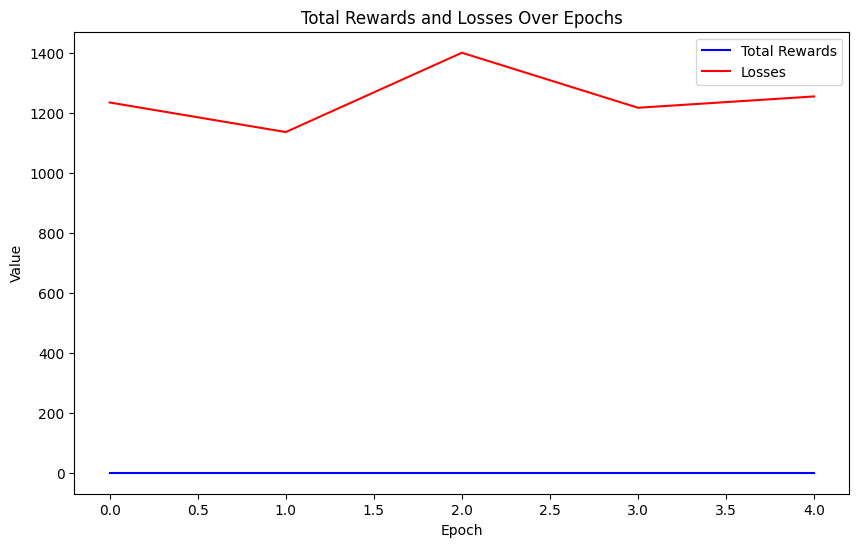

TC_c 66115.39499999999
TC_i 235836.22499999995
TC 301951.61999999994


In [42]:
training_loop(5, 1)
